In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2b.ok')

Assignment: proj2b
OK, version v1.13.11



In [5]:
conda install basemap

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /srv/conda/envs/data100

  added / updated specs:
    - basemap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    basemap-1.2.0              |   py37h705c2d8_0        14.4 MB
    geos-3.6.2                 |       heeff764_2         1.2 MB
    openssl-1.1.1g             |       h7b6447c_0         2.5 MB
    proj4-5.2.0                |       he6710b0_1         6.6 MB
    pyproj-1.9.6               |   py37h14380d9_0          69 KB
    pyshp-2.1.0                |             py_0          35 KB
    ------------------------------------------------------------
                                           Total:        24.9 MB

The f

# Project 2 Part B: Spam/Ham Classification
## Classifiers
### The assignment is due on Monday, April 27th at 11:59pm PST.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In Project 2 Part A, you made an effort to understand the data through EDA, and did some basic feature engineering. You also built a Logistic Regression model to classify Spam/Ham emails. In Part B, you will learn how to evaluate the classifiers you built. You will also have the chance to improve your model by selecting more features.

## Warning
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Score Breakdown
Question | Points
--- | ---
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 6
8 | 6
9 | 15
Total | 37

## Setup

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [48]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

Using version already downloaded: Sat Apr 25 18:12:43 2020
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sat Apr 25 18:12:44 2020
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


The following code is adapted from Part A of this project. You will be using it again in Part B.

In [49]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email']) 
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), array([0, 0, 0, 0, 0]))

Recall that you trained the following model in Part A.

In [50]:
from sklearn.linear_model import LogisticRegression

model =  LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

The model you trained doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [51]:
zero_predictor_fp = 0
zero_predictor_fn = len(train[train['spam']==1])
zero_predictor_fn

1918

In [52]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [53]:
zero_predictor_acc = len(train[train['spam']==0])/len(train)
zero_predictor_recall = 0
zero_predictor_acc

0.7447091707706642

In [54]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Explain why the number of false positives, number of false negatives, accuracy, and recall all turned out the way they did.

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

From 6a:

The zero predictor is always going to be 0 and always will not be a positive but will always be a false positive of 0.
To continue with the zero predictor, this will never predict a true positive and will only predict a false negative which is the total number of spam emails.

From 6b:

In order to get the accuracy we need to divide the total number of ham emails by the total number of emails and zero predictor is 0 because there is no way that a positive be ever predicted.


False Positive: we want to know the number of ham emails that are flagged as spam and filtered out of the inbox, FN,
accuracy, recall

False Negative: we want to know the number of spam emails that are mislabeled as hams and ends up in the inbox.

accuracy: we want to know how many hams are labeled correctly out of the total number of emails

recall: want to know how many spams are labeled as spam, since it's zero predictor, so no spam is labeled.

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Part A. Do **NOT** use any `sklearn` functions.

**Note: In lecture we used the `sklearn` package to compute the rates. Here you should work through them using just the definitions to help build a deeper understanding.**

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [55]:
Y_train_hat = model.predict(X_train)
TP_FP=np.sum(Y_train_hat)
TP=np.sum(Y_train_hat&Y_train)
FP=TP_FP-TP
FN=np.sum(Y_train)-TP
TN=np.sum(Y_train==0)-FP
logistic_predictor_precision = TP/TP_FP
logistic_predictor_recall = TP/(TP+FN)
logistic_predictor_far = FP/(FP+TN)

In [56]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Part A?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

In [57]:
FP,FN

(122, 1699)

Here our FP=122, and FN=1699, so we can see that there are more false negatives compared to false positive

### Question 6f

1. Our logistic regression classifier got 75.8% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

1. By predicting 0 for every email our yields 74.47%, which is less than 75.8%, therefore our logistic regression
   classifier is better.
   
2. The words are common in both spam and ham emails, such as the words memo and private for example.

3. I prefer the logistic regression classifier for a spam filter, since it has higher prediction accuracy.

## Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

**Kaggle limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on the entire set when submitting to Kaggle (the accuracy that will determine your score for question 9).

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [58]:
train

,id,subject,email,spam
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0
...,...,...,...,...
5734,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0
5191,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale...",1
5390,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0
860,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0


In [59]:
from sklearn.linear_model import LogisticRegressionCV
import re
# looking for words in a bag, idea from lecture
def word_bags(df):
    word_count_list = {}
    for email in df['email']:
        word_list = re.findall('\w+', email)
        for w in word_list:
                word_count_list[w] = (word_count_list[w] + 1) if w in word_count_list else 1
    return word_count_list

train_word_bag = (pd.Series(word_bags(train)) / train.shape[0]).sort_values(ascending=False)[:200]

# Finds all Re: in the subject
def is_re(df):
    return df["subject"].apply(lambda x: 1 if x and not pd.isnull(x) and "Re:" in x else 0)
# Finds all Fw: in the subject
def is_forward(df):
    return df["subject"].apply(lambda x: 1 if x and not pd.isnull(x) and "Fw:" in x else 0)
# finds all the words that are free
def contains_free(df):
    return df['email'].str.findall('free').str.len()
#  creating a function that looks through the text body for words and numbers
def body_words(df):
    return df['email'].str.findall('\w+').str.len()
# Goes through the subject and gets the number and percentage of letters
def capital_subject(df):
    return (df['subject'].str.findall(r'[A-Z]').str.len() / df['subject'].str.len()).fillna(0)
# creating a function that looks for numbers and the percentage of the letters
def capital_content(df):
    return df['email'].str.findall(r'[A-Z]').str.len() / df['email'].str.len()
# finds the numuber of non char within the subject
def non_charactor_subject(df):
    return (df['subject'].str.findall('[^A-Za-z0-9]').str.len() / df['subject'].str.len()).fillna(0)
# find the number of html tags
def html_tag(df):
    return df["email"].str.count("/>")
# finds ip address
def ip_addr(df):
    return df["email"].str.findall('[0-9]{1,3}(\.[0-9]{1,3}){3}').str.len() > 0
# Utalizes all functions above and takes some words and puts it into a series. This will process the dataset
def process(df):
    some_words = ['drug', 'bank', '$', 'free', 'money', '!','offer', 'business', 'body', 'html', 'please','account', 'buy', 'gift','good'] + train_word_bag.index.tolist()
    X_train = np.array(words_in_texts(some_words, df['email'])).astype(int)
    pun = df['email'].str.findall('!').str.len().fillna(0)
    feature = pd.concat([body_words(df),is_re(df),is_forward(df),html_tag(df),ip_addr(df),contains_free(df),capital_content(df),capital_subject(df),non_charactor_subject(df),pun], axis=1).values
    X_train = np.concatenate((X_train, feature), axis=1)
    return X_train

X_train = process(train)
Y_train = train['spam']

# creating model and getting training accuracy
model = LogisticRegressionCV(Cs=4, fit_intercept=True, cv=10, verbose =1, random_state=42)
model.fit(X_train, Y_train)
training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Training Accuracy:  0.9728470650871822


/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Question 7: Feature/Model Selection Process

In the following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

1. The way I found my better features for my model was to find all of the suggested feature recommendation which involved me creating functions for each of the suggested feature recommendation

2. During this process I tried to include more functions that didn't seem to work or were too complicated to code, so I stayed with the function that worked. Another thing I tried was I looked through some of my spam emails to see which words were common in order to get a better grasp as to what words appeared frequently with in those emails

3. In my search through my spam emails I found that the words that appeared frequently within my emails also appeared frequently within the dataset as well. This was pretty surprising since it seems that these are pretty common words that appear in a lot spam emails.

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

(0, 80)

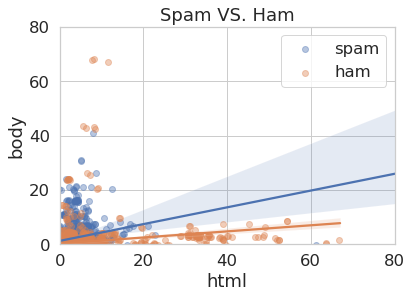

In [60]:
# Write your description (2-3 sentences) as a comment here:
# There is a alot of frequency between body and html occuring at the same time considering the fact that these are 
# both main types of html tags. In the ham section we ca see that there is some variantion after the 20 mark. We can 
# also see that within these categories, that spam has more content (aka body) compared to ham. This would indicate
# that there is alot of non-sense within these emails but this could also be because there are urls involved, which may
# lead to longer bodys/content. Lastly ham seems to end around the mid 60 mark which would mean there is more spam 
# then ham

# Write the code to generate your visualization here:
hams = train[train['spam'] == 0]
spams = train[train['spam'] == 1]

def TagCt(df, name):
    return df['email'].str.findall(name).str.len()
ax = sns.regplot(x=TagCt(spams,'html'),y=TagCt(spams,'body'),x_jitter=0.5, y_jitter=0.5, label = "spam", scatter_kws= {"alpha":0.4})
ax = sns.regplot(x=TagCt(hams,'html'),y=TagCt(hams,'body'),x_jitter=0.5, y_jitter=0.5, label = "ham", scatter_kws= {"alpha":0.4})
ax.legend()
plt.title("Spam VS. Ham")
plt.xlabel('html')
plt.ylabel('body')
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
# Note: if your plot doesn't appear in the PDF, you should try uncommenting the following line:
# plt.show()

# Question 9: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/t/c76d80f7d3204159865a324ec2936f18

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the test set and the score does not depend on your ranking on Kaggle. 

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q9
points: 15
-->

In [61]:
X_test = process(test)
test_predictions = model.predict(X_test)
test_predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,

In [62]:
ok.grade("q9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [63]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2020-04-26T23:00:54.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 5 EXPORTED QUESTIONS -->

In [44]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2b.ipynb', 'proj2b.pdf')
ok.submit()

Generating PDF...
Saved proj2b.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj2b.ipynb'.
Submit... 100% complete
Submission successful for user: jeremym777@berkeley.edu
URL: https://okpy.org/cal/data100/sp20/proj2b/submissions/RPLLBz

